In [90]:
from hydra import compose, initialize
from omegaconf import OmegaConf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from retail_agent.utils.storage_util import CloudStorageUtil
from retail_agent.utils.viz_util import plot_stacked_arm_purchase_prob_for_arms
from retail_agent.utils.metric_util import make_mi_scores

%reload_ext autoreload
%autoreload 2

# Reproduction of figures and tables from the paper

We organize each section with the labels of corresponding figures and tables in the paper. To pull the data requires AWS credentials tied to a private repository, due to the large volume of data and potential costs associated with downloading it. Please contact the repository maintainers if you are interested in accessing the raw data.

In [4]:
with initialize(version_base=None, config_path="../workflow/cfg"):
    config = compose(config_name="agent_training")
    config = OmegaConf.to_object(config)

In [5]:
def load_summary_data(storage, scenario="no_marketing", scenario_name="Brand Loyalty"):
    files = storage.list_dir(f"11c50_{scenario}_100customers_2514products/summary/")
    df_files = {}
    segmented_df_files = {}
    for file in files:
        if "_all_customer_dfs.pkl" in file:
            file_name = file.replace("_all_customer_dfs.pkl", "").split("/")[-1]
            df_files[file_name] = storage.load_obj(file)
        elif "_segmented_dfs.pkl" in file:
            file_name = file.replace("_segmented_dfs.pkl", "").split("/")[-1]
            segmented_df_files[file_name] = storage.load_obj(file)

    df_files["benchmark"]["metric_df"] = pd.concat([df_files["benchmark"]["metric_df"]] * 10).reset_index(drop=True)
    dfs = {}
    for key in list(df_files.values())[0].keys():
        df = pd.concat([df[key] for df in list(df_files.values())], ignore_index=True)
        df["scenario"] = scenario_name
        dfs[key] = df

    segmented_df_files["benchmark"]["metric_df"] = pd.concat([segmented_df_files["benchmark"]["metric_df"]] * 10).reset_index(drop=True)
    segmented_dfs = {}
    for key in list(segmented_df_files.values())[0].keys():
        df = pd.concat([df[key] for df in list(segmented_df_files.values())], ignore_index=True)
        df["scenario"] = scenario_name
        segmented_dfs[key] = df

    return dfs, segmented_dfs

Load experiment results from aws s3 bucket.

In [72]:
storage = CloudStorageUtil(config["cloud"])
no_marketing_dfs, no_marketing_segmented_dfs = load_summary_data(storage, scenario="no_marketing", scenario_name="Brand Loyalty")
dfs = {key: pd.concat([no_marketing_dfs[key]], ignore_index=True) for key in no_marketing_dfs.keys()}
segmented_dfs = {key: pd.concat([no_marketing_segmented_dfs[key]], ignore_index=True) for key in no_marketing_dfs.keys()}

features = storage.load_obj("11c50_no_marketing_100customers_2514products/summary/feature_selection_data.pkl")

## Figure 2. Evaluation of benchmark policies

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)]


/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/4255038337.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_label, fontsize=label_size)
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/4255038337.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xtick_label, fontsize=label_size)


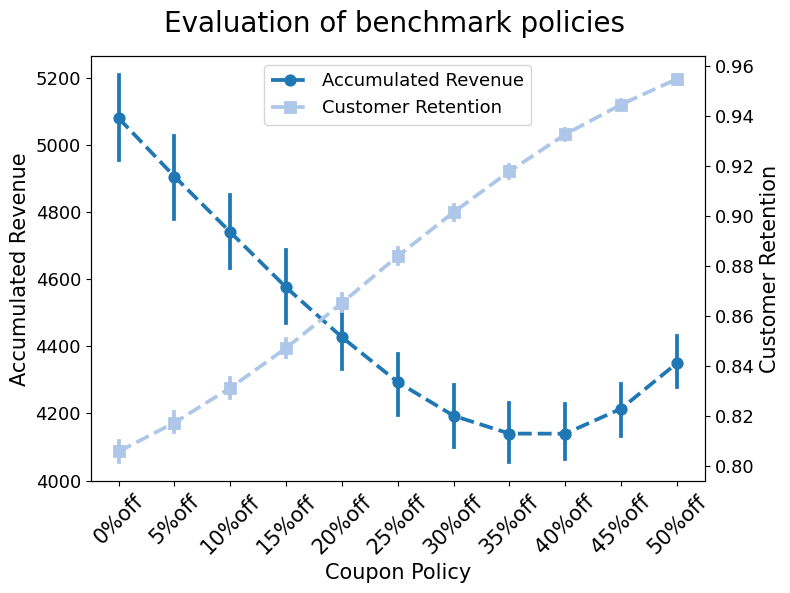

In [75]:
benchmark = ["FixedArm_0", "FixedArm_1", "FixedArm_2", "FixedArm_3", "FixedArm_4", "FixedArm_5", "FixedArm_6", "FixedArm_7", "FixedArm_8", "FixedArm_9", "FixedArm_10"]
tick_size = 13
label_size = 15
title_size = 18
legend_size = 13
suptitle_size = 20
selected_metric_df = dfs["metric_df"][dfs["metric_df"]["agent"].isin(benchmark)]
color_palette = sns.color_palette("tab20", 2)
print(color_palette)
xtick_label = ["0%off", "5%off", "10%off", "15%off", "20%off", "25%off", "30%off", "35%off", "40%off", "45%off", "50%off", "random(25%off)"]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(data=selected_metric_df, x="agent", y="accumulated_revenue", ax=ax, errorbar="ci", order=benchmark, linestyles="--", color=color_palette[0], label="Accumulated Revenue", legend=False)
ax2 = ax.twinx()
sns.pointplot(data=selected_metric_df, x="agent", y="customer_retention", ax=ax2, errorbar="ci", order=benchmark, linestyles="--", color=color_palette[1], markers="s", label="Customer Retention", legend=False)
ax.tick_params(axis="x", rotation=45)
ax2.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", labelsize=tick_size)
ax2.tick_params(axis="y", labelsize=tick_size)
ax.set_xticklabels(xtick_label, fontsize=label_size)
ax2.set_xticklabels(xtick_label, fontsize=label_size)
ax.set_ylabel("Accumulated Revenue", fontsize=label_size)
ax2.set_ylabel("Customer Retention", fontsize=label_size)
ax.set_xlabel("Coupon Policy", fontsize=label_size)


lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax.legend(lines, labels, loc="upper center", fontsize=legend_size)

fig.suptitle("Evaluation of benchmark policies", fontsize=suptitle_size)
plt.tight_layout()

Accumulated revenue and customer retention when applying fixed coupon policies to 100 separate simulations of 100 customers over 70 time steps. Metrics collected from last 20 time steps to match evaluation period used for agent training.

## Table 1. Mean and standard error of metrics for all agents

### Table of mean metrics for all agents

In [81]:
n_feature = 9
selected_agents = ["FixedArm_0", f"LinTS{n_feature}f_1000", f"LinUCB{n_feature}f_1000", f"NeuralBoltzmann{n_feature}f_1000", f"PPO{n_feature}f_1000", f"DQN{n_feature}f_1000"]

# compute the ratio of metrics normalized by random agent
random_agent_baseline = dfs["metric_df"].query("agent == 'random_agent'").groupby(["env_id", "scenario"]).mean()
metric_df_in_ratio = (dfs["metric_df"].groupby(["agent", "env_id", "scenario"]).mean() / random_agent_baseline).groupby(["scenario", "agent"]).mean().reset_index()
mean_selected_agents = metric_df_in_ratio[metric_df_in_ratio.agent.isin(selected_agents)]
mean_selected_agents = mean_selected_agents.sort_values(by=["scenario", "accumulated_revenue"], ascending=False).set_index("agent")

mean_selected_agents.loc[selected_agents]

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/1230215172.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_agent_baseline = dfs["metric_df"].query("agent == 'random_agent'").groupby(["env_id", "scenario"]).mean()


,scenario,accumulated_revenue,accumulated_demand,customer_retention,category_penetration,empirical_discount
agent,,,,,,
FixedArm_0,Brand Loyalty,1.117736,0.629287,0.902180,0.629287,0.000000
LinTS9f_1000,Brand Loyalty,1.259119,1.391915,0.992335,1.391915,0.688826
LinUCB9f_1000,Brand Loyalty,1.258596,1.389263,0.992768,1.389263,0.688233
NeuralBoltzmann9f_1000,Brand Loyalty,1.068445,0.879559,0.972052,0.879559,0.644105
PPO9f_1000,Brand Loyalty,1.255371,1.309701,0.976030,1.309701,0.578323
DQN9f_1000,Brand Loyalty,0.955566,1.494534,1.054221,1.494534,1.709045


### Table of standard error of mean metrics for all agents

In [80]:
# compute the standard error of the mean
random_agg = random_agent_baseline.agg(["mean", "var"])
non_random_mean = dfs["metric_df"].query("agent != 'random_agent'").groupby(["scenario", "agent"]).mean()
non_random_var = dfs["metric_df"].query("agent != 'random_agent'").groupby(["scenario", "agent"]).var()
non_random_se = ((non_random_var / random_agg.loc["mean"] ** 2 + random_agg.loc["var"] * (non_random_mean**2) / random_agg.loc["mean"] ** 4) ** (1 / 2) / 10).reset_index()
se_selected_agents = non_random_se[non_random_se.agent.isin(selected_agents)].set_index("agent")
se_selected_agents.loc[selected_agents]

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/4066850239.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  non_random_mean = dfs["metric_df"].query("agent != 'random_agent'").groupby(["scenario", "agent"]).mean()
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/4066850239.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  non_random_var = dfs["metric_df"].query("agent != 'random_agent'").groupby(["scenario", "agent"]).var()


,scenario,accumulated_revenue,accumulated_demand,customer_retention,category_penetration,empirical_discount
agent,,,,,,
FixedArm_0,Brand Loyalty,0.059265,0.019575,0.009028,0.019575,0.000000
LinTS9f_1000,Brand Loyalty,0.061975,0.044760,0.007455,0.044760,0.022582
LinUCB9f_1000,Brand Loyalty,0.061935,0.044933,0.007492,0.044933,0.022536
NeuralBoltzmann9f_1000,Brand Loyalty,0.055583,0.030066,0.008173,0.030066,0.026828
PPO9f_1000,Brand Loyalty,0.062272,0.046641,0.008101,0.046641,0.024329
DQN9f_1000,Brand Loyalty,0.044597,0.053579,0.006822,0.053579,0.019580


Summary of agent performance metrics normalized relative to a random policy (with a value of 1 indicating performance equal to the random policy). The mean and standard error of each metric are reported based on 10 learned policies, evaluated over 10,000 customers and across 20 time steps.

### T-test on accumulated revenue across agents

In [83]:
scenario = "Brand Loyalty"
agent_1 = "random_agent"
metric = "accumulated_revenue"

for agent in selected_agents:
    record_1 = dfs["metric_df"].query(f"agent == '{agent_1}'").query(f"scenario == '{scenario}'")[metric]
    record_2 = dfs["metric_df"].query(f"agent == '{agent}'").query(f"scenario == '{scenario}'")[metric]

    print(f"scenario: {scenario}, agent: {agent}, p-value: {stats.ttest_rel(record_1, record_2, alternative='less').pvalue}")

scenario: Brand Loyalty, agent: FixedArm_0, p-value: 4.089620655415288e-236
scenario: Brand Loyalty, agent: LinTS9f_1000, p-value: 0.0
scenario: Brand Loyalty, agent: LinUCB9f_1000, p-value: 0.0
scenario: Brand Loyalty, agent: NeuralBoltzmann9f_1000, p-value: 1.9238679920148865e-121
scenario: Brand Loyalty, agent: PPO9f_1000, p-value: 0.0
scenario: Brand Loyalty, agent: DQN9f_1000, p-value: 1.0


Identify the agent that performs significantly better than the random agent, determined by a t-test on the accumulated revenue distributions when p-valie < 0.05.

## Figure 3-(a). Customer segmentation

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/2966086876.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a = features.groupby("segment").mean()


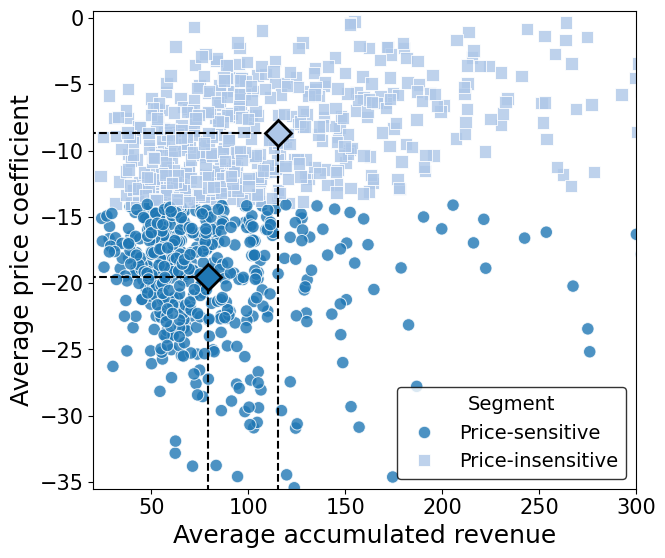

In [48]:
legend_size = 14
label_size = 18
title_size = 18
tick_size = 15
palette = "tab20"
colors = sns.color_palette(palette, 2)
fig, ax = plt.subplots(1, 1, figsize=(7, 6.2))
sns.scatterplot(data=features, y="price_sensitivity_coef", x="reward", hue=features["segment"], alpha=0.8, ax=ax, palette=palette, legend=True, s=80, style="segment", markers={0: "o", 1: "s"})
ax.set_ylim(-35.5, 0.5)
ax.set_xlim(20, 300)
ax.tick_params(axis="both", labelsize=tick_size)
ax.set_xlabel("Average accumulated revenue", fontsize=label_size)
ax.set_ylabel("Average price coefficient", fontsize=label_size)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=[handles[0], handles[1]], loc="lower right", title="Segment", labels=["Price-sensitive", "Price-insensitive"], fontsize=legend_size, title_fontsize=legend_size, frameon=True)
legend.set_alpha(0)
frame = legend.get_frame()
frame.set_edgecolor("black")
a = features.groupby("segment").mean()
for i in range(len(colors)):
    plt.vlines(a.loc[i, "reward"], -45, a.loc[i, "price_sensitivity_coef"], linestyle="--", color="black")
    plt.hlines(a.loc[i, "price_sensitivity_coef"], 0, a.loc[i, "reward"], linestyle="--", color="black")
    plt.plot(a.loc[i, "reward"], a.loc[i, "price_sensitivity_coef"], marker="D", markeredgecolor="black", color=colors[i], markersize=13, markeredgewidth=2)

The average accumulated revenue of customer segments with different price sensitivities. Customers in the price-sensitive and price-insensitive segments have average price coefficients greater than or less than the median. Diamond indicators show the mean values of the price coefficient and revenue for each segment.

## Figure 3-(b). Probability of arm selection by segments

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/3778482646.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=tick_size)


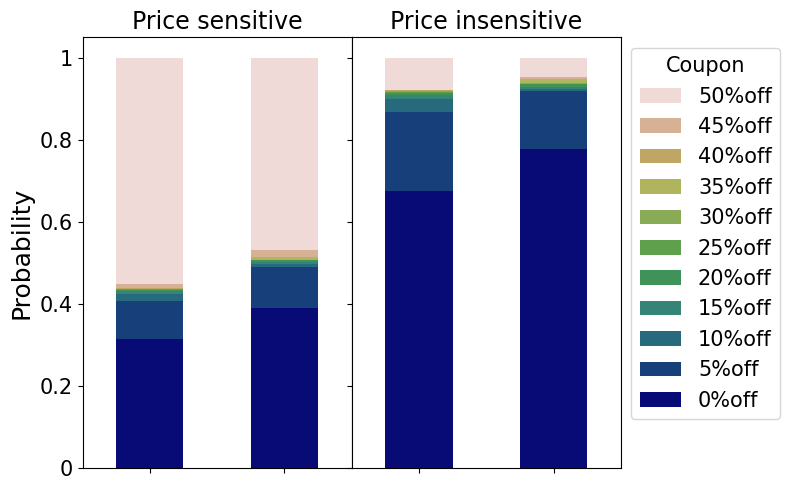

In [84]:
# Original colormap
original_cmap = plt.cm.gist_earth  # Replace with your desired colormap

# Define the fraction of the middle part to take
subset_fraction = 1  # Adjust as needed
upper_bound = 0.95
lower_bound = 0.05

# Calculate the start and end indices of the middle part
n_colors = original_cmap.N
start_index = int((1 - subset_fraction) / 2 * n_colors)
end_index = int((1 + subset_fraction) / 2 * n_colors)

# Extract the subset of colors from the original colormap
colors_subset = original_cmap(np.linspace(lower_bound, upper_bound, end_index - start_index))

# Create a custom colormap using the subset of colors
custom_cmap = LinearSegmentedColormap.from_list("subset_cmap", colors_subset)

n_feature = 9
selected_agents = [f"LinUCB{n_feature}f_1000", f"PPO{n_feature}f_1000"]
labels = ["0%off", "5%off", "10%off", "15%off", "20%off", "25%off", "30%off", "35%off", "40%off", "45%off", "50%off"]
title = ["Price sensitive", "Price insensitive"]
tick_size = 15
label_size = 18
title_size = 17
legend_size = 15
suptitle_size = 18
selected_arm_df = segmented_dfs["selected_arm_df"][(segmented_dfs["selected_arm_df"].agent.isin(selected_agents))]
selected_metric_segmented_df = segmented_dfs["metric_df"][segmented_dfs["metric_df"]["agent"].isin(selected_agents)]
discount_df = selected_metric_segmented_df.groupby(["scenario", "agent", "segment"])["empirical_discount"].mean()
fig, axes = plt.subplots(
    1,
    len(selected_agents),
    figsize=(len(selected_agents) * 4, 5),
)
for i, ax in enumerate(axes):
    temp_df = selected_arm_df[selected_arm_df.segment == i]
    plot_stacked_arm_purchase_prob_for_arms(temp_df, ax=ax, hue="agent", colormap=custom_cmap, grid=False, style={"edgecolor": ["black"] * 11})
    ax.set_title(selected_agents[i])
    ax.set_xticklabels(
        ["", ""],
        fontsize=tick_size,
    )
    if i == 0:
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=tick_size)
        ax.set_ylabel("Probability", fontsize=label_size)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_title(title[i], fontsize=title_size)
    ax.set_xlabel("", fontsize=label_size)
handle, _ = axes[-1].get_legend_handles_labels()
handle.reverse()
labels.reverse()
axes[-1].legend(bbox_to_anchor=(1, 1), handles=handle, labels=labels, title="Coupon", fontsize=legend_size, title_fontsize=legend_size)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [85]:
random_agent_baseline = segmented_dfs["metric_df"].query("agent == 'random_agent'").groupby(["env_id", "scenario", "segment"]).mean()
selected_metric_df = segmented_dfs["metric_df"][segmented_dfs["metric_df"]["agent"].isin(selected_agents)]
metric_df_in_ratio = (selected_metric_df.groupby(["agent", "env_id", "scenario", "segment"]).mean() / random_agent_baseline).reset_index()
metric_df_in_ratio = metric_df_in_ratio.groupby(["scenario", "agent", "segment"]).mean()
report_table = pd.DataFrame([metric_df_in_ratio["accumulated_revenue"], discount_df])
report_table.index = ["Normalized accumulated revenue", "Empirical coupon"]
report_table.loc["Normalized accumulated revenue"] = report_table.loc["Normalized accumulated revenue"].apply("{:.2f}".format)
report_table.loc["Empirical coupon"] = report_table.loc["Empirical coupon"].apply("{:.2%}".format)
report_table

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/15551724.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_agent_baseline = segmented_dfs["metric_df"].query("agent == 'random_agent'").groupby(["env_id", "scenario", "segment"]).mean()
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/15551724.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_df_in_ratio = metric_df_in_ratio.groupby(["scenario", "agent", "segment"]).mean()


scenario                       Brand Loyalty                         
agent                          LinUCB9f_1000        PPO9f_1000       
segment                                    0      1          0      1
Normalized accumulated revenue          1.30   1.23       1.28   1.24
Empirical coupon                      29.09%  5.65%     25.31%  3.92%

Coupon offer probability distributions by segment shown in the bar chart. The table shows average accumulated revenue of each agent normalized relative to the random policy and the actual average coupon discount value.

## Appendix Figure 4. Feature analysis and selection

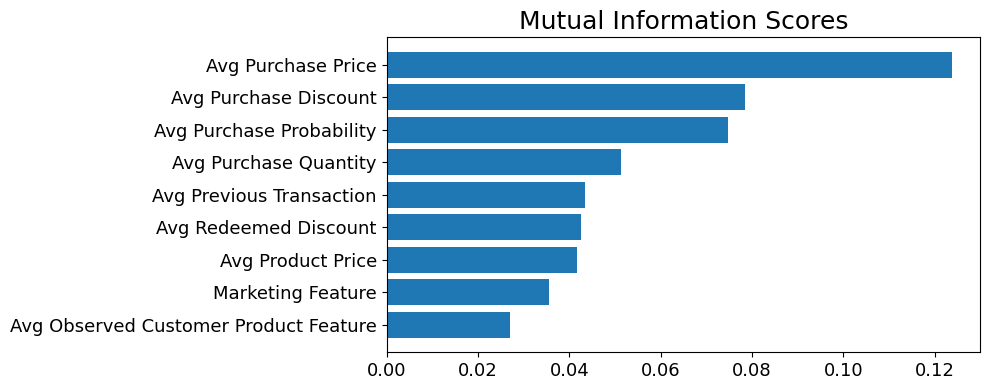

In [66]:
mi_scores = make_mi_scores(features, frac=1)
tick_size = 13
title_size = 18
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = [
    "Avg Observed Customer Product Feature",
    "Marketing Feature",
    "Avg Product Price",
    "Avg Redeemed Discount",
    "Avg Previous Transaction",
    "Avg Purchase Quantity",
    "Avg Purchase Probability",
    "Avg Purchase Discount",
    "Avg Purchase Price",
]
plt.barh(width, scores)
plt.yticks(width, ticks, fontsize=tick_size)
plt.xticks(fontsize=tick_size)
plt.title("Mutual Information Scores", fontsize=title_size)
plt.tight_layout()

Mutual Information scores of manually prepared features ranked in descending order.

## Appendix Figure 5. Sensitivity study on training size

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/474746305.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_agent_baseline = metric_df.query("agent == 'random_agent'").groupby(["env_id", "scenario"]).mean()
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/474746305.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.loc[:, "n_feature"] = selected_df["agent"].str.extract(r"(\d+)f_", expand=False).fillna(0).astype(int)
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/474746305.py:8: Setting

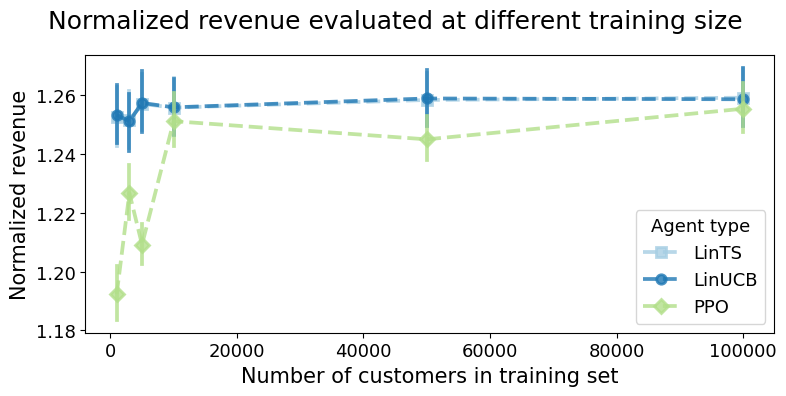

In [86]:
metric_df = dfs["metric_df"]
selected_agents = metric_df["agent"][(metric_df["agent"].str.startswith("LinUCB9f")) | (metric_df["agent"].str.startswith("LinTS9f")) | (metric_df["agent"].str.startswith("PPO9f"))]
random_agent_baseline = metric_df.query("agent == 'random_agent'").groupby(["env_id", "scenario"]).mean()
metric_df = (metric_df.groupby(["agent", "env_id", "scenario"]).mean() / random_agent_baseline).reset_index()

selected_df = metric_df[metric_df.agent.isin(selected_agents)]
selected_df.loc[:, "n_feature"] = selected_df["agent"].str.extract(r"(\d+)f_", expand=False).fillna(0).astype(int)
selected_df.loc[:, "agent_type"] = selected_df["agent"].str.extract(r"([A-Za-z]+)\d+", expand=False).fillna(selected_df["agent"])
selected_df.loc[:, "n_customer"] = selected_df["agent"].str.extract(r"f_(\d+)", expand=False).fillna(0).astype(int) * 100


tick_size = 13
label_size = 15
title_size = 18
legend_size = 13
suptitle_size = 20

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
sns.pointplot(data=selected_df, x="n_customer", y="accumulated_revenue", hue="agent_type", ax=ax1, linestyles="--", legend=True, native_scale=True, errorbar="ci", alpha=0.8, markers=["s", "o", "D"], palette="Paired")

ax1.set_xlabel("Number of customers in training set", fontsize=label_size)
ax1.set_ylabel("Normalized revenue", fontsize=label_size)
ax1.tick_params(axis="x", labelsize=tick_size)
ax1.tick_params(axis="y", labelsize=tick_size)
ax1.legend(fontsize=legend_size, title="Agent type", title_fontsize=legend_size)
fig.suptitle("Normalized revenue evaluated at different training size", fontsize=title_size)
plt.tight_layout()

Impact of training data size on agents' accumulated revenue normalized by the random agent.

## Appendix Figure 6. Reward distribution by segments

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_30382/103967795.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(xtick_label, fontsize=label_size)


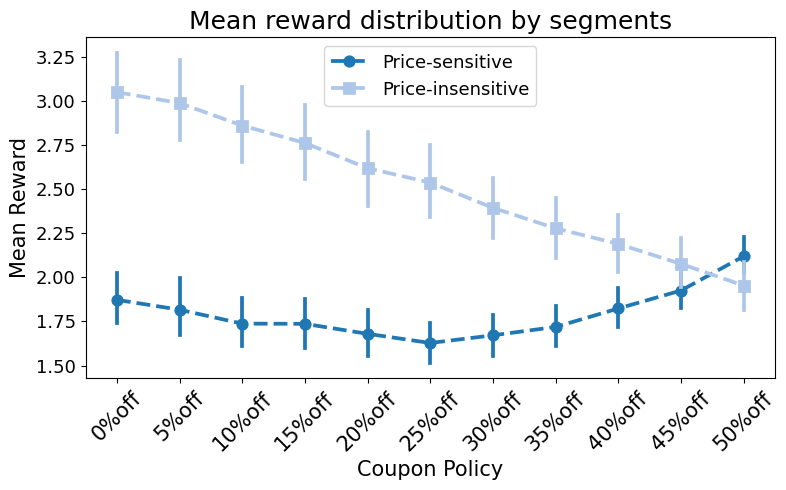

In [70]:
tick_size = 13
label_size = 15
title_size = 18
legend_size = 13
suptitle_size = 20
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 5))
avg_reward = features.groupby(["env_id", "action", "segment"])["reward"].mean().reset_index()
sns.pointplot(avg_reward, y="reward", x="action", hue="segment", palette="tab20", log_scale=False, ax=ax1, legend=legend, linestyles="--", markers=["o", "s"])
ax1.tick_params(axis="both", labelsize=tick_size)
handles, _ = ax1.get_legend_handles_labels()
labels = ["Price-sensitive", "Price-insensitive"]
ax1.legend(handles=handles, labels=["Price-sensitive", "Price-insensitive"], loc="upper center", fontsize=legend_size)
xtick_label = ["0%off", "5%off", "10%off", "15%off", "20%off", "25%off", "30%off", "35%off", "40%off", "45%off", "50%off", "random(25%off)"]
ax1.set_xticklabels(xtick_label, fontsize=label_size)
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylabel("Mean Reward", fontsize=label_size)
ax1.set_xlabel("Coupon Policy", fontsize=label_size)
ax1.set_title("Mean reward distribution by segments", fontsize=title_size)
plt.tight_layout()

Distribution of mean reward by customer segments and coupon offers in the offline dataset collected under Algorithm